In [16]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%autoreload 2
from datetime import datetime
import matplotlib.pyplot as plt
from neural_analysis import spectra
import numpy as np
import sys
from tqdm.autonotebook import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from utils import save, load

### 1) Initialize Parameters

In [82]:
T = 125 # s, duration of time series
dt = 0.02 # s, time step
D_r = 300 # number of reservoir nodes
d = 6 # average degree of Erdos-Renyi network
rho = 1.2 # spectral radius of the adjacency matrix

beta = 0 # regularization parameter
# beta = 1e-4 # regularization parameter
sigma = 0.1 # maximum value of the input weights

squared_inds = None
# squared_inds = []
# squared_inds = np.random.choice(np.arange(D_r), size=(int(D_r/2),), replace=False)

var_names = ['x', 'y', 'z']

# initial_condition = None 
# initial_condition = (-8, -7, 29)
initial_condition = (-8.01304744, -6.58865759, 28.60202532)

### 2) Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\rho = 28$, $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [83]:
lorenz_pts = simulate_lorenz(dt=dt, T=T, initial_condition=initial_condition)

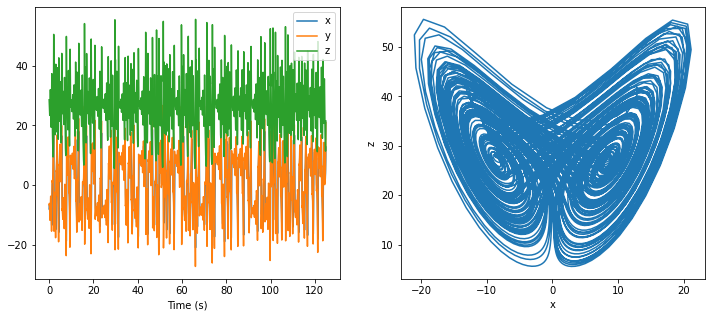

In [20]:
time_vals = np.arange(len(lorenz_pts))*dt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

### Build the Network

In [84]:
reservoir = ReservoirDS(lorenz_pts, dt=dt, D_r=D_r, d=d, rho=rho, beta=beta, sigma=sigma, squared_inds=squared_inds, var_names=var_names)

The average degree of the network is 5.99


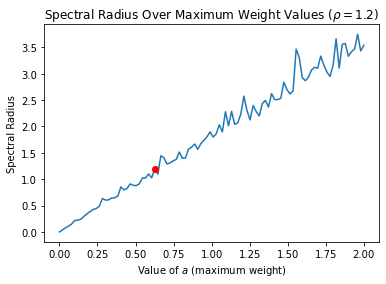

The spectral radius is 1.196


In [137]:
reservoir.build_connectivity(debug=True)

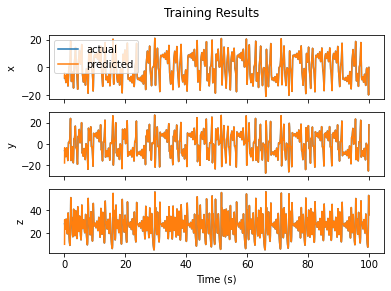

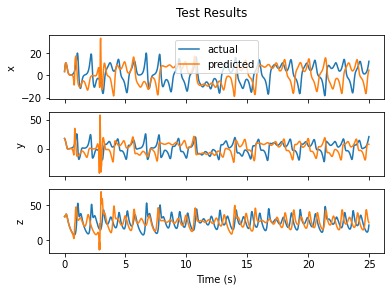

In [138]:
reservoir.train_and_test(debug=True)

In [139]:
# POWER SPECTRAL DENSITY

In [140]:
power_spectra = []
for i in range(reservoir.D):
    spec_true, freqs_true = spectra.spectrum(reservoir.u[reservoir.num_steps_train:, i], smp_rate=1/reservoir.dt, spec_type='power', freq_range=[0, 80])
    spec_test, freqs_test = spectra.spectrum(reservoir.v_test[:, i], smp_rate=1/reservoir.dt, spec_type='power', freq_range=[0, 80])
    power_spectra.append({'true': {'spec': spec_true, 'freqs': freqs_true}, 'test': {'spec': spec_test, 'freqs': freqs_test}, 'mse': ((spec_test - spec_true)**2).mean()})

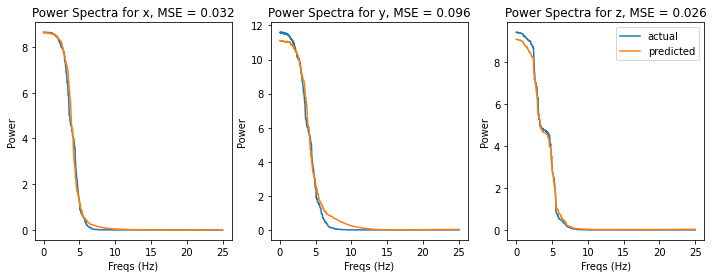

In [141]:
plt.figure(figsize=(12, 4))
for i in range(reservoir.D):
    plt.subplot(1, 3, i+1)
    plt.plot(power_spectra[i]['true']['freqs'], power_spectra[i]['true']['spec'], label='actual')
    plt.plot(power_spectra[i]['test']['freqs'], power_spectra[i]['test']['spec'], label='predicted')
    plt.title(f"Power Spectra for {reservoir.var_names[i]}, MSE = {power_spectra[i]['mse']:.3f}")
    plt.xlabel('Freqs (Hz)')
    plt.ylabel('Power')
plt.legend()
plt.show()

In [142]:
# timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# save(reservoir, f'../../__data__/reservoir {timestamp}.pkl')

In [148]:
loading_filepath = "/Users/adameisen/Documents/MIT/2021 Summer/ChaoticConsciousness/__data__/reservoir 2021-06-11 12:27:21.pkl"
reservoir = load(loading_filepath)

## Jacobian

In [149]:
def sech(x):
    return 1/np.cosh(x)

def jacobian(reservoir):
    J = np.zeros((reservoir.num_steps_test, reservoir.D_r, reservoir.D_r))
    
    for t in range(-1, reservoir.num_steps_test - 1):
        if t < 0:
            r = reservoir.r_train[-1]
            v = reservoir.v_train[-1]
        else:
            r = reservoir.r_test[t]
            v = reservoir.v_test[t]
            
        D1 = np.diag(sech(reservoir.A @ r + reservoir.W_in @ reservoir.P @ r)**2)
        W_feedback = reservoir.W_in @ reservoir.P
        W_feedback[:, reservoir.squared_inds] *= 2*r[reservoir.squared_inds]
        D2 = reservoir.A + W_feedback
        J[t+1] = D1 @ D2
        
    return J

In [150]:
J = jacobian(reservoir)

In [151]:
def lyap_spectrum_QR(Js,T):
    K,n = Js.shape[0],Js.shape[-1]    
    Q,R = np.linalg.qr(Js[0])
    lyaps = np.zeros((n,))

    for t in range(1,K):
        Q = Js[t] @ Q
        

        # Need diagonal of R to be positive, so rewrite Q = Q @ S and R = S @ R, where S_ii = sign(R_ii)
        S = np.diag(np.sign(np.diag(R)))
#         print(np.diag(S@R))
        lyaps += np.log(np.diag(S @ R))
        
        Q = Q @ S

        #add diagonal of R to running lyapunov spectrum estimate
        
        Q,R = np.linalg.qr(Q)

    lyaps /= T
    
    return lyaps

In [152]:
lyaps = lyap_spectrum_QR(J, reservoir.num_steps_test*reservoir.dt)

In [153]:
lyaps[:3]

array([ 12.39288457,  -1.34216953, -14.65251373])